# Predicting Heart Disease based on Cleveland's Dataset

Group 11: Rui Xiang Yu, Laurent Mbabazi & Dilay Aykut

## 1. Introduction

Heart disease is a broad term that encompasses medical conditions that primarily affect coronary arteries, heart rhythm, and the heart's health. It is notoriously hard to diagnose due to the requirement of several variables needing to simultaneously point towards the same conclusion.

The Cleveland Heart Disease Dataset found on the UCI Machine Learning Repository comprises information on 303 individuals (206 men and 97 women), with an age range of 29 to 77 and 14 variables. Our research question was what is a person's heart diagnosis based on five specific predictors; the predictors being age, sex, ST depression induced by exercise, number of major vessels, and maximum heart rate. The main aim is to have a model that is as accurate as possible given the heavy implications of a misdiagnosis.

## 2. Methods & Results

### 2.1. Loading and tidying data

The first step will be loading all necessary libraries. Then, the data is loaded from the internet. Finally, the data is tidied.

In [1]:
# Loading the libraries.
library(tidyverse)
library(tidymodels)
library(dplyr)
library(readr)
library(cowplot)
library(recipes)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#Loading data into R, selecting interested columns and previewing first 6 rows.
heart <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                  col_names = c("age", "sex", "chestpaintype", "restbps", 
                                "cholesterolserum", "fastingbs", "restecg",
                                "maxheartrate", "exerciseangina", "oldpeak",
                                "slope", "nmajorvessels", "thalassemia", 
                                "diagnosis"))                               %>%
         mutate(diagnosis = as_factor(diagnosis))                           %>%
         select(age, sex, oldpeak, nmajorvessels, 
                fastingbs, maxheartrate, diagnosis)

head(heart)

#Looking at how many missing values are in each variable:
colSums(is.na(heart))

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  chestpaintype = col_double(),
  restbps = col_double(),
  cholesterolserum = col_double(),
  fastingbs = col_double(),
  restecg = col_double(),
  maxheartrate = col_double(),
  exerciseangina = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  nmajorvessels = col_character(),
  thalassemia = col_character(),
  diagnosis = col_double()
)



age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,1,2.3,0.0,1,150,0
67,1,1.5,3.0,0,108,2
67,1,2.6,2.0,0,129,1
37,1,3.5,0.0,0,187,0
41,0,1.4,0.0,0,172,0
56,1,0.8,0.0,0,178,0


age           sex       oldpeak nmajorvessels     fastingbs 
            0             0             0             0             0 
 maxheartrate     diagnosis 
            0             0

Figure 1.1. ...

In this dataset, each variable has the following meaning:
- `age`: age of the person recorded, in years.
- `sex`: biological sex of the person recorded, with 0 meaning female and 1 meaning male.
- `oldpeak`: ST depression induced by exercise.
- `nmajorvessels`: the number of vessels.
- `fastingbs`: fasting blood sugar rate in milligrams over deciliter (mg/dl), with 0 meaning under 120 and 1 meaning over 120.
- `maxheartrate`: the maximum heart rate of the person recorded, in beats per minute (BPM).
- `diagnosis`: indication of presence of heart disease, with 0 meaning none and 1-4 meaning there is presence.

In [5]:
# A closer look shows that nmajorvessels has 4 NA values that should be filtered.
heart_closeup <- heart %>%
filter(nmajorvessels == "?") %>%
select(nmajorvessels) %>%
count()
heart_closeup

n
<int>
4


Figure 1.2. ...

In [6]:
# Removing the missing data in nmajorvessels
heart_filtered <- heart                                                      %>%
                  filter(nmajorvessels != "?")

head(heart_filtered)

age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,1,2.3,0.0,1,150,0
67,1,1.5,3.0,0,108,2
67,1,2.6,2.0,0,129,1
37,1,3.5,0.0,0,187,0
41,0,1.4,0.0,0,172,0
56,1,0.8,0.0,0,178,0


Figure 1.3. ...

In [11]:
# Since values other than 0 for diagnosis means presence of heart disease, 1-4 values are lumped into 1.
# Number of major vessels is converted into numeric. Diagnosis is recoded to ease
# understanding of its values and converted into factors for graphing.
heart_disease <- heart_filtered                                             %>%
                 mutate(diagnosis = fct_lump(diagnosis, other_level = "1")) %>%
                 mutate(nmajorvessels = as.numeric(nmajorvessels))          %>%
                 mutate(diagnosis = recode_factor(diagnosis, `1` = "Yes",
                                                  `0` = "No"))

head(heart_disease)

age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,2.3,0,1,150,No
67,1,1.5,3,0,108,Yes
67,1,2.6,2,0,129,Yes
37,1,3.5,0,0,187,No
41,0,1.4,0,0,172,No
56,1,0.8,0,0,178,No


Figure 1.4. ...

Here is the final, clean and tidy data.

### 2.2. Summary and exploratory data analysis

First, the dataset will be split into a training set and testing set, to be able to perform exploratory data analysis on the training set. A summary table will be produced as an initiator and then more indicative plots will be created.

In [15]:
#Splitting the data and looking at number of rows for each set.
set.seed(11)

heart_split <- initial_split(heart_disease, prop = 0.70, strata = diagnosis)
heart_train <- training(heart_split)
heart_test  <- testing(heart_split)


nrow(heart_train)
nrow(heart_test)

[1] 210

[1] 89

In [16]:
#Looking at the means/ratio of each predictor for each type of diagnosis.
group_summary <- heart_train                                                %>% 
                 group_by(diagnosis)                                        %>% 
                 summarize(size = n(),
                            age_mean = mean(age),
                            maxheartrate_mean = mean(maxheartrate),
                            oldpeak_mean = mean(oldpeak),
                            nmajorvessels_mean = mean(nmajorvessels),
                            sex_fraction_female = sum(sex == "0")/n(),
                            sex_fraction_male = sum(sex == "1")/n(),
                            fastingbs_fraction_over_120 = 
                                             sum(fastingbs == "1")/n(),
                            fastingbs_fraction_under_120 = 
                                             sum(fastingbs == "0")/n())

group_summary

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,size,age_mean,maxheartrate_mean,oldpeak_mean,nmajorvessels_mean,sex_fraction_female,sex_fraction_male,fastingbs_fraction_over_120,fastingbs_fraction_under_120
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Yes,97,57.14433,138.3402,1.535052,1.1855670,0.1134021,0.8865979,0.1340206,0.8659794
No,113,52.23009,159.6726,0.600000,0.2920354,0.4247788,0.5752212,0.1592920,0.8407080


Figure 2.1. ...

In [17]:
#Looking at overall means for numeric predictors.
heart_means <- heart_train                                               %>%
               select(age, maxheartrate, oldpeak, nmajorvessels)         %>%
               map_df(mean)
heart_means

age,maxheartrate,oldpeak,nmajorvessels
<dbl>,<dbl>,<dbl>,<dbl>
54.5,149.819,1.031905,0.7047619


Figure 2.2....

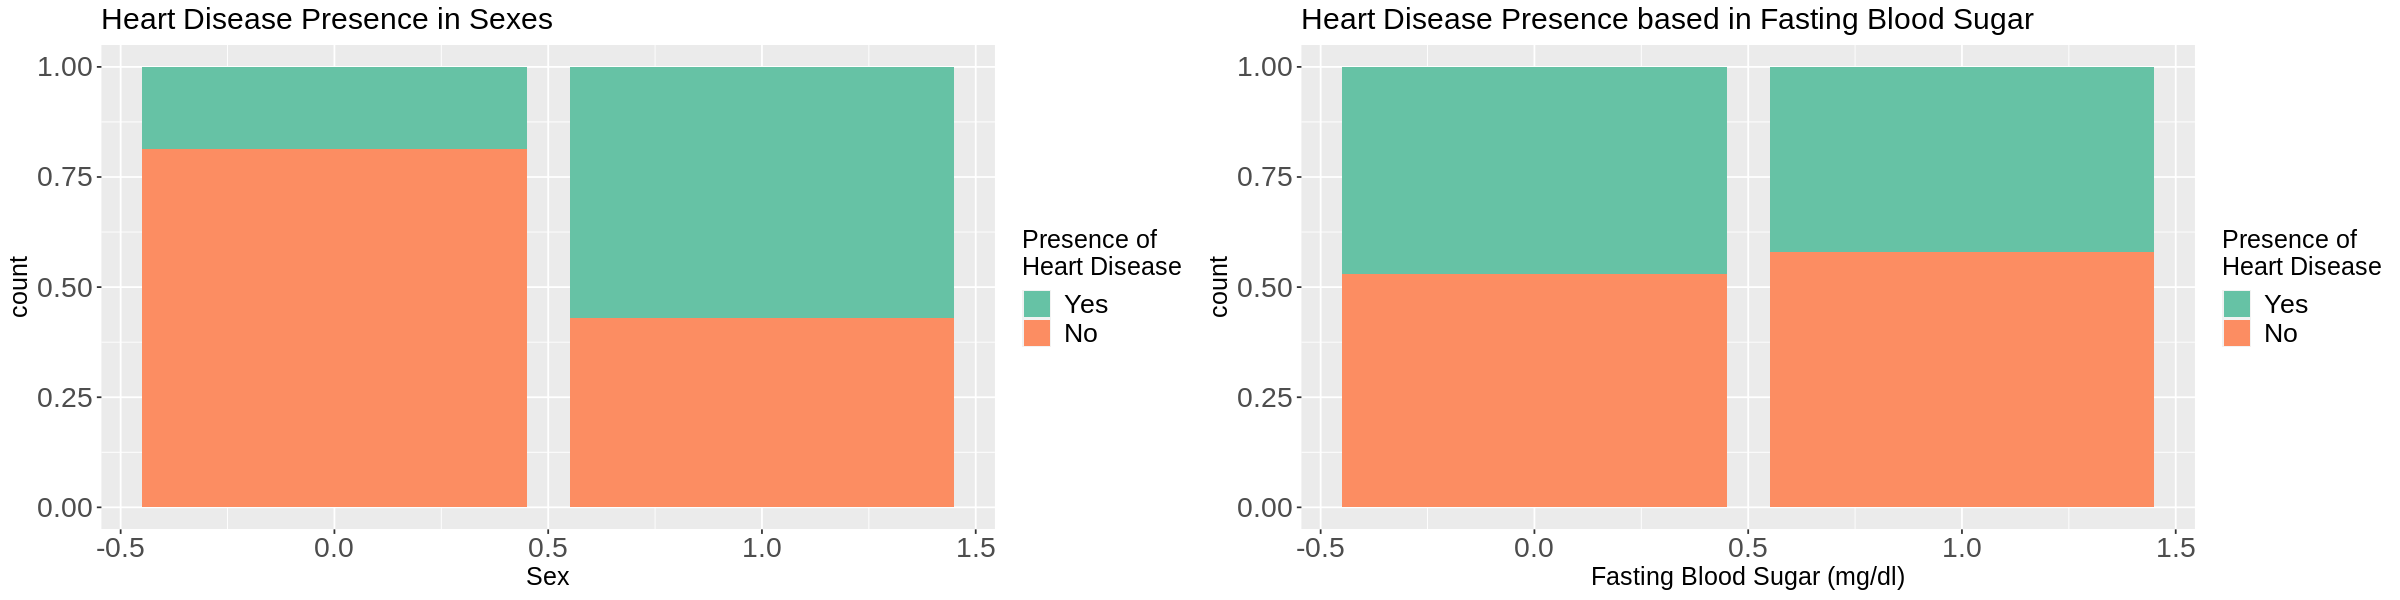

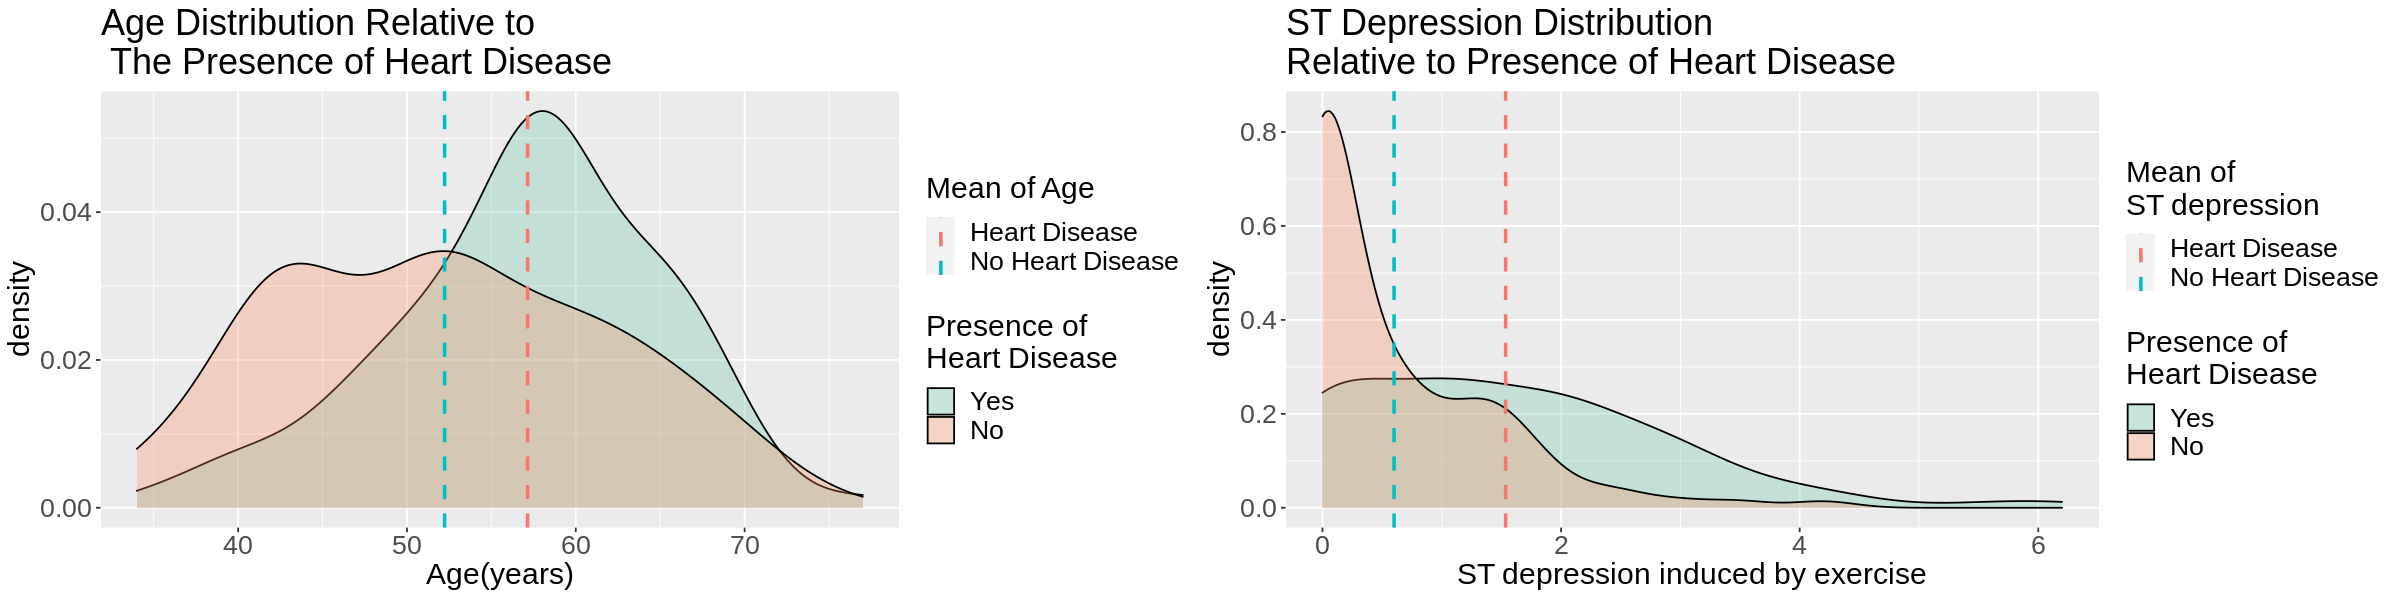

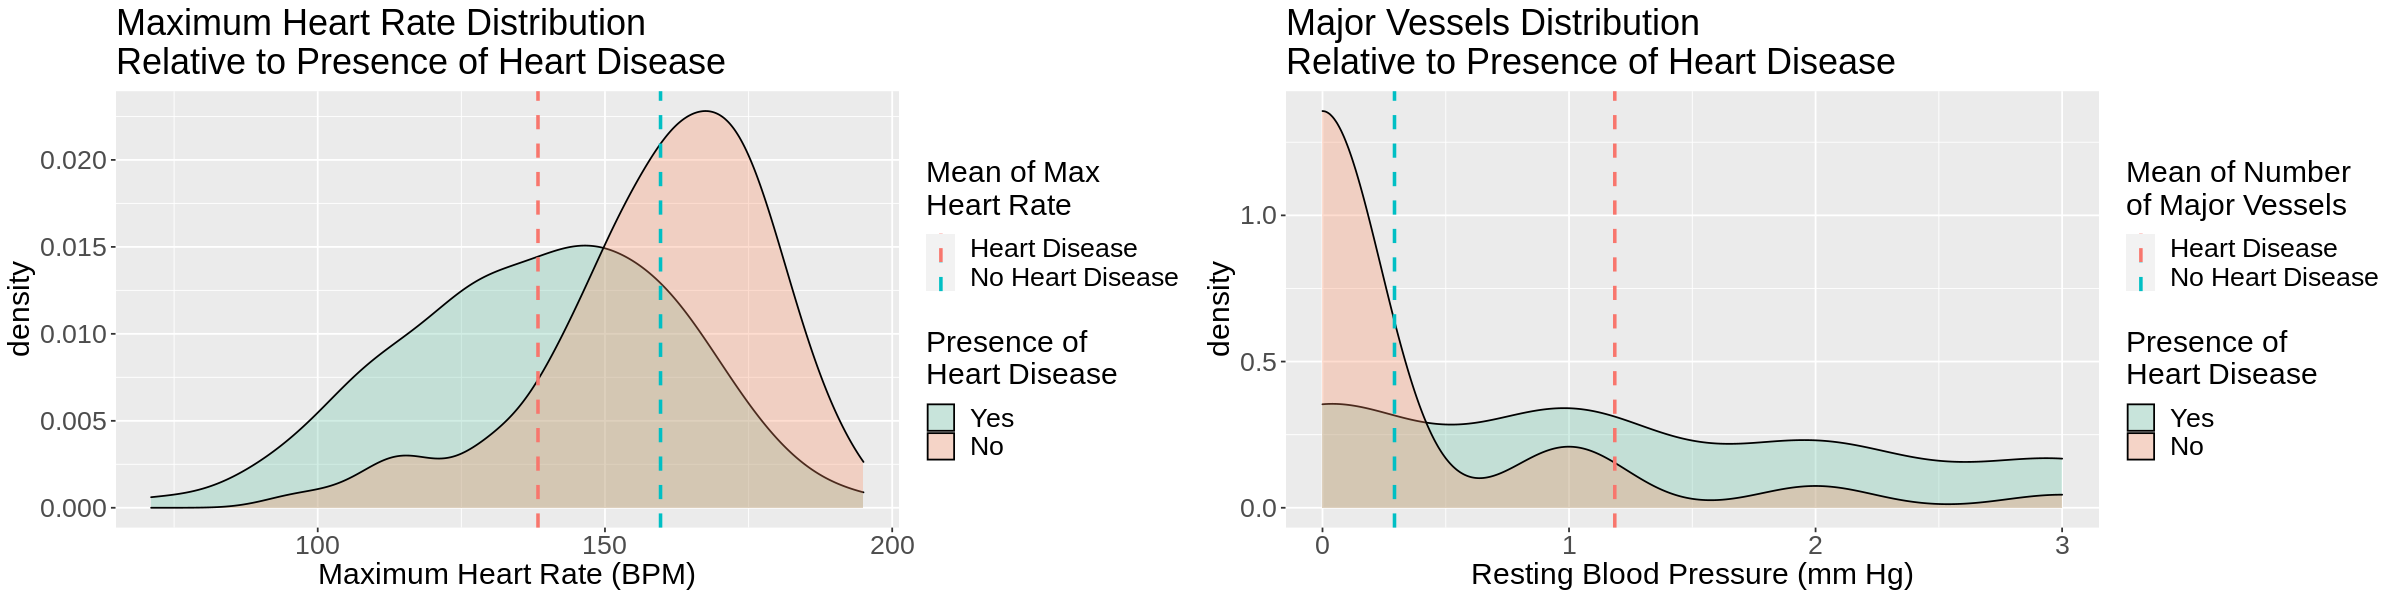

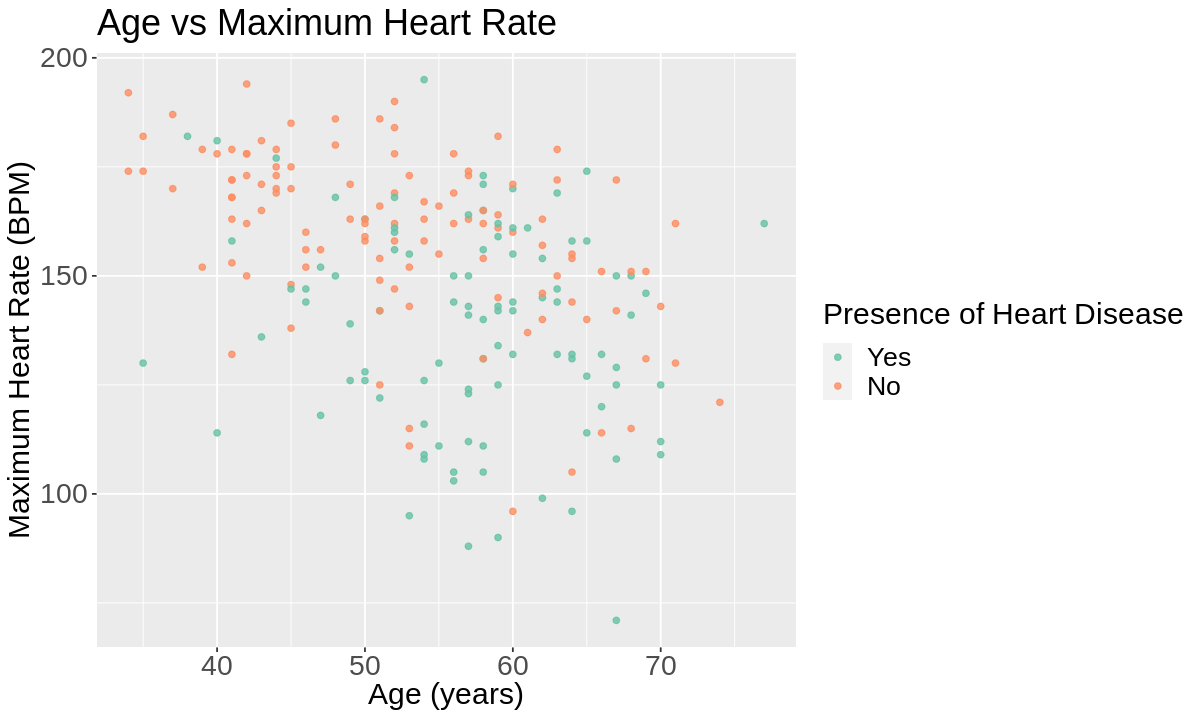

In [18]:
#Visualizing different relevant plots with training data.
options(repr.plot.width = 20, repr.plot.height = 5) 

#Plotting a bar graph looking at presence of heart disease based in the sex.

sex_plot <- ggplot(heart_train, aes(x = sex, fill = diagnosis))             +
             geom_bar(position = "fill")                                    +
             labs(x = "Sex", fill = "Presence of \nHeart Disease")          +
             ggtitle("Heart Disease Presence in Sexes")                     +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

# Plotting a bar graph looking at presence of heart disease based on fasting 
# blood sugar level.

bs_plot  <- ggplot(heart_train, aes(x = fastingbs, fill = diagnosis))       +
             geom_bar(position = "fill")                                    +
             labs(x = "Fasting Blood Sugar (mg/dl)", 
                  fill = "Presence of \nHeart Disease")                     +
             ggtitle("Heart Disease Presence based in Fasting Blood Sugar") +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

#Looking at age distribution

age_plot  <- ggplot(heart_train, aes(x = age, fill = diagnosis))            +
              geom_density(alpha = 0.3)                                     +
              geom_vline(data = group_summary, 
                         aes(xintercept = age_mean, color = diagnosis),
                             linetype = "dashed", size = 1)                 +
              labs(x     = "Age(years)", 
                   fill  = "Presence of \nHeart Disease", 
                   color = "Mean of Age")                                   +
              scale_color_hue(labels = c("Heart Disease", 
                                         "No Heart Disease"))               +
    ggtitle("Age Distribution Relative to \n The Presence of Heart Disease")+
              theme(text  = element_text(size = 20),
                    title = element_text(size = 18))                        +
              scale_fill_brewer(palette = "Set2")

#Looking at ST depression induced by exercise distribution

peak_plot <- ggplot(heart_train, aes(x = oldpeak, fill = diagnosis))        +
              geom_density(alpha = 0.3)                                     +
              geom_vline(data = group_summary, 
                         aes(xintercept = oldpeak_mean, 
                             color = diagnosis),
                             linetype="dashed", size=1)                     +
              labs(x     = "ST depression induced by exercise", 
                   fill  = "Presence of \nHeart Disease", 
                   color = "Mean of \nST depression")                       +
              scale_color_hue(labels = c("Heart Disease", 
                                         "No Heart Disease"))               +
ggtitle("ST Depression Distribution \nRelative to Presence of Heart Disease")+
              theme(text  = element_text(size = 20),
                    title = element_text(size = 18))                         +
              scale_fill_brewer(palette = "Set2")

#Looking at maximum heart rate distribution

heartrate_plot <- ggplot(heart_train, 
                         aes(x = maxheartrate, fill = diagnosis))           +
                   geom_density(alpha = 0.3)                                +
                   geom_vline(data    = group_summary, 
                              aes(xintercept = maxheartrate_mean, 
                                  color      = diagnosis),
                                  linetype   = "dashed", 
                                  size       = 1)                           +
                   labs(x     = "Maximum Heart Rate (BPM)", 
                        fill  = "Presence of \nHeart Disease", 
                        color = "Mean of Max \nHeart Rate")                 +
                   scale_color_hue(labels = c("Heart Disease", 
                                              "No Heart Disease"))          +
ggtitle("Maximum Heart Rate Distribution \nRelative to Presence of Heart Disease")+
                   theme(text = element_text(size = 20),
                        title = element_text(size = 18))                    +
                   scale_fill_brewer(palette = "Set2")
      
#Looking at number of major vessels distribution

vessel_plot <- ggplot(heart_train, 
                      aes(x = nmajorvessels, fill = diagnosis))             +
                geom_density(alpha = 0.3)                                   +
                geom_vline(data = group_summary, 
                           aes(xintercept = nmajorvessels_mean, 
                               color      = diagnosis),
                               linetype   = "dashed", 
                               size       = 1)                              +
                labs(x     = "Resting Blood Pressure (mm Hg)", 
                     fill  = "Presence of \nHeart Disease", 
                     color = "Mean of Number \nof Major Vessels")           +
            scale_color_hue(labels = c("Heart Disease", "No Heart Disease"))+
ggtitle("Major Vessels Distribution \nRelative to Presence of Heart Disease")+
                     theme(text  = element_text(size = 20),
                           title = element_text(size = 18))                 +
                scale_fill_brewer(palette = "Set2")
      
plot_grid(sex_plot, bs_plot,           ncol = 2)
plot_grid(age_plot, peak_plot,         ncol = 2)
plot_grid(heartrate_plot, vessel_plot, ncol = 2)

#Plotting a scatter plot with Age vs Maximum Heart Rate
age_heart <- ggplot(heart_train, aes(x = age, y = maxheartrate, 
                                       color = diagnosis))                  +
              geom_point(alpha = 0.8)                                       +
              labs(x = "Age (years)", y = "Maximum Heart Rate (BPM)", 
                   color = "Presence of Heart Disease")                     +
              ggtitle("Age vs Maximum Heart Rate")                          +
              theme(text = element_text(size = 20),
                    axis.text.x = element_text(size = 17),
                    axis.text.y = element_text(size = 17),
                    title       = element_text(size = 18))                  +
              scale_color_brewer(palette = "Set2")

options(repr.plot.width = 10, repr.plot.height = 6)
age_heart

### 2.3. Classification analysis

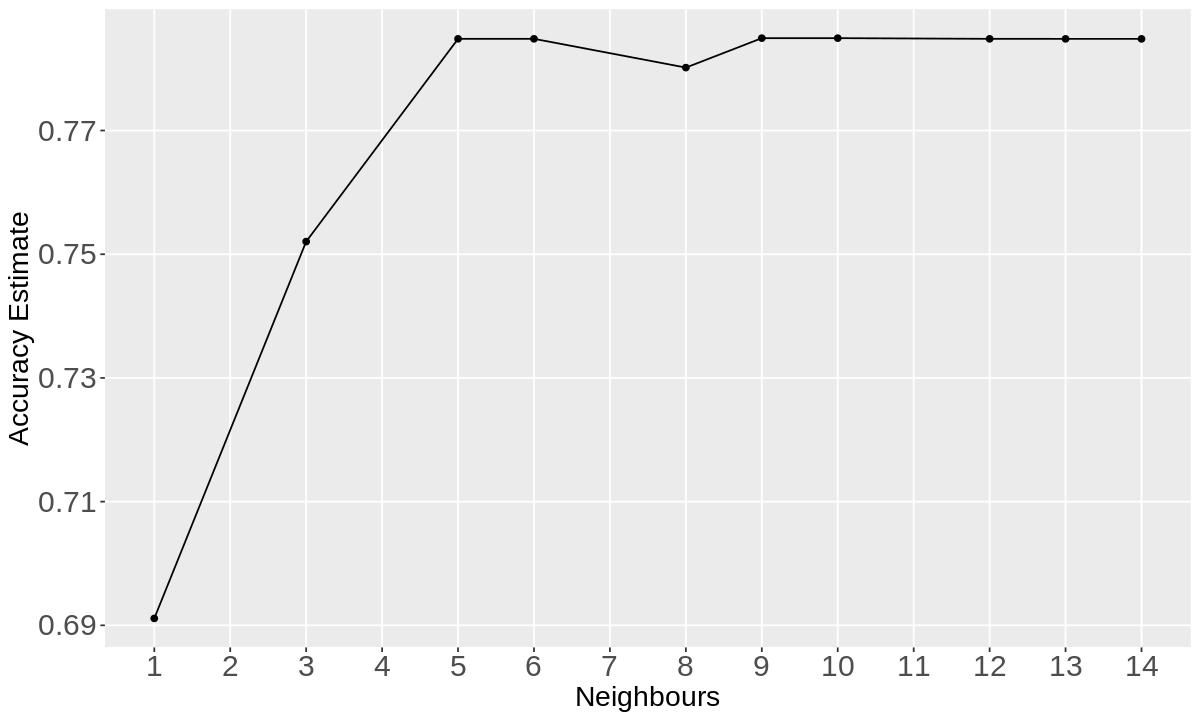

In [19]:
#Recipe, model, fit.
set.seed(11)
options(repr.plot.width = 10, repr.plot.height = 6)

heart_recipe  <- recipe(diagnosis ~ ., data = heart_train)                  %>%
                 step_scale(all_predictors())                               %>%
                 step_center(all_predictors())

heart_vfold   <- vfold_cv(heart_train, v = 5, strata = diagnosis)

knn_spec      <- nearest_neighbor(weight_func = "rectangular", 
                                  neighbors   = tune())                     %>%
                 set_engine("kknn")                                         %>%
                 set_mode("classification")

heart_results <- workflow()                                                 %>%
                 add_recipe(heart_recipe)                                   %>%
                 add_model(knn_spec)                                        %>%
                 tune_grid(resamples = heart_vfold, grid = 10)              %>%
                 collect_metrics()

accuracy      <- heart_results                                              %>%
                 filter(.metric == "accuracy")

accuracy_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))             +
                  geom_point()                                              +
                  geom_line()                                               +
                  labs(x = "Neighbours", y = "Accuracy Estimate")           + 
                  scale_x_continuous(breaks = seq(1, 14))                   +
                  theme(text        = element_text(size = 17),
                        axis.text.x = element_text(size = 18),
                        axis.text.y = element_text(size = 18),
                        panel.grid.minor = element_blank())

accuracy_plot

In [20]:
set.seed(11)

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5)  %>%
              set_engine("kknn")                                            %>%
              set_mode("classification")

heart_fit  <- workflow()                                                    %>%
              add_recipe(heart_recipe)                                      %>%
              add_model(heart_spec)                                         %>%
              fit(data = heart_train)


heart_predictions <- predict(heart_fit, heart_test)                         %>%
                     bind_cols(heart_test)

heart_metrics     <- heart_predictions                                      %>%
                     metrics(truth = diagnosis, estimate = .pred_class)     %>%
                     filter(.metric == "accuracy")

heart_conf_mat    <- heart_predictions                                      %>%
                     conf_mat(truth = diagnosis, estimate = .pred_class)

number_accuracy   <- heart_predictions                                      %>%
                     metrics(truth = diagnosis, estimate = .pred_class)     %>%
                     filter(.metric == "accuracy")

heart_conf_mat
number_accuracy

          Truth
Prediction  0  1
         0 40 11
         1  8 30

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7865169


### 2.4. Visualization of the performed analysis

`summarise()` ungrouping output (override with `.groups` argument)


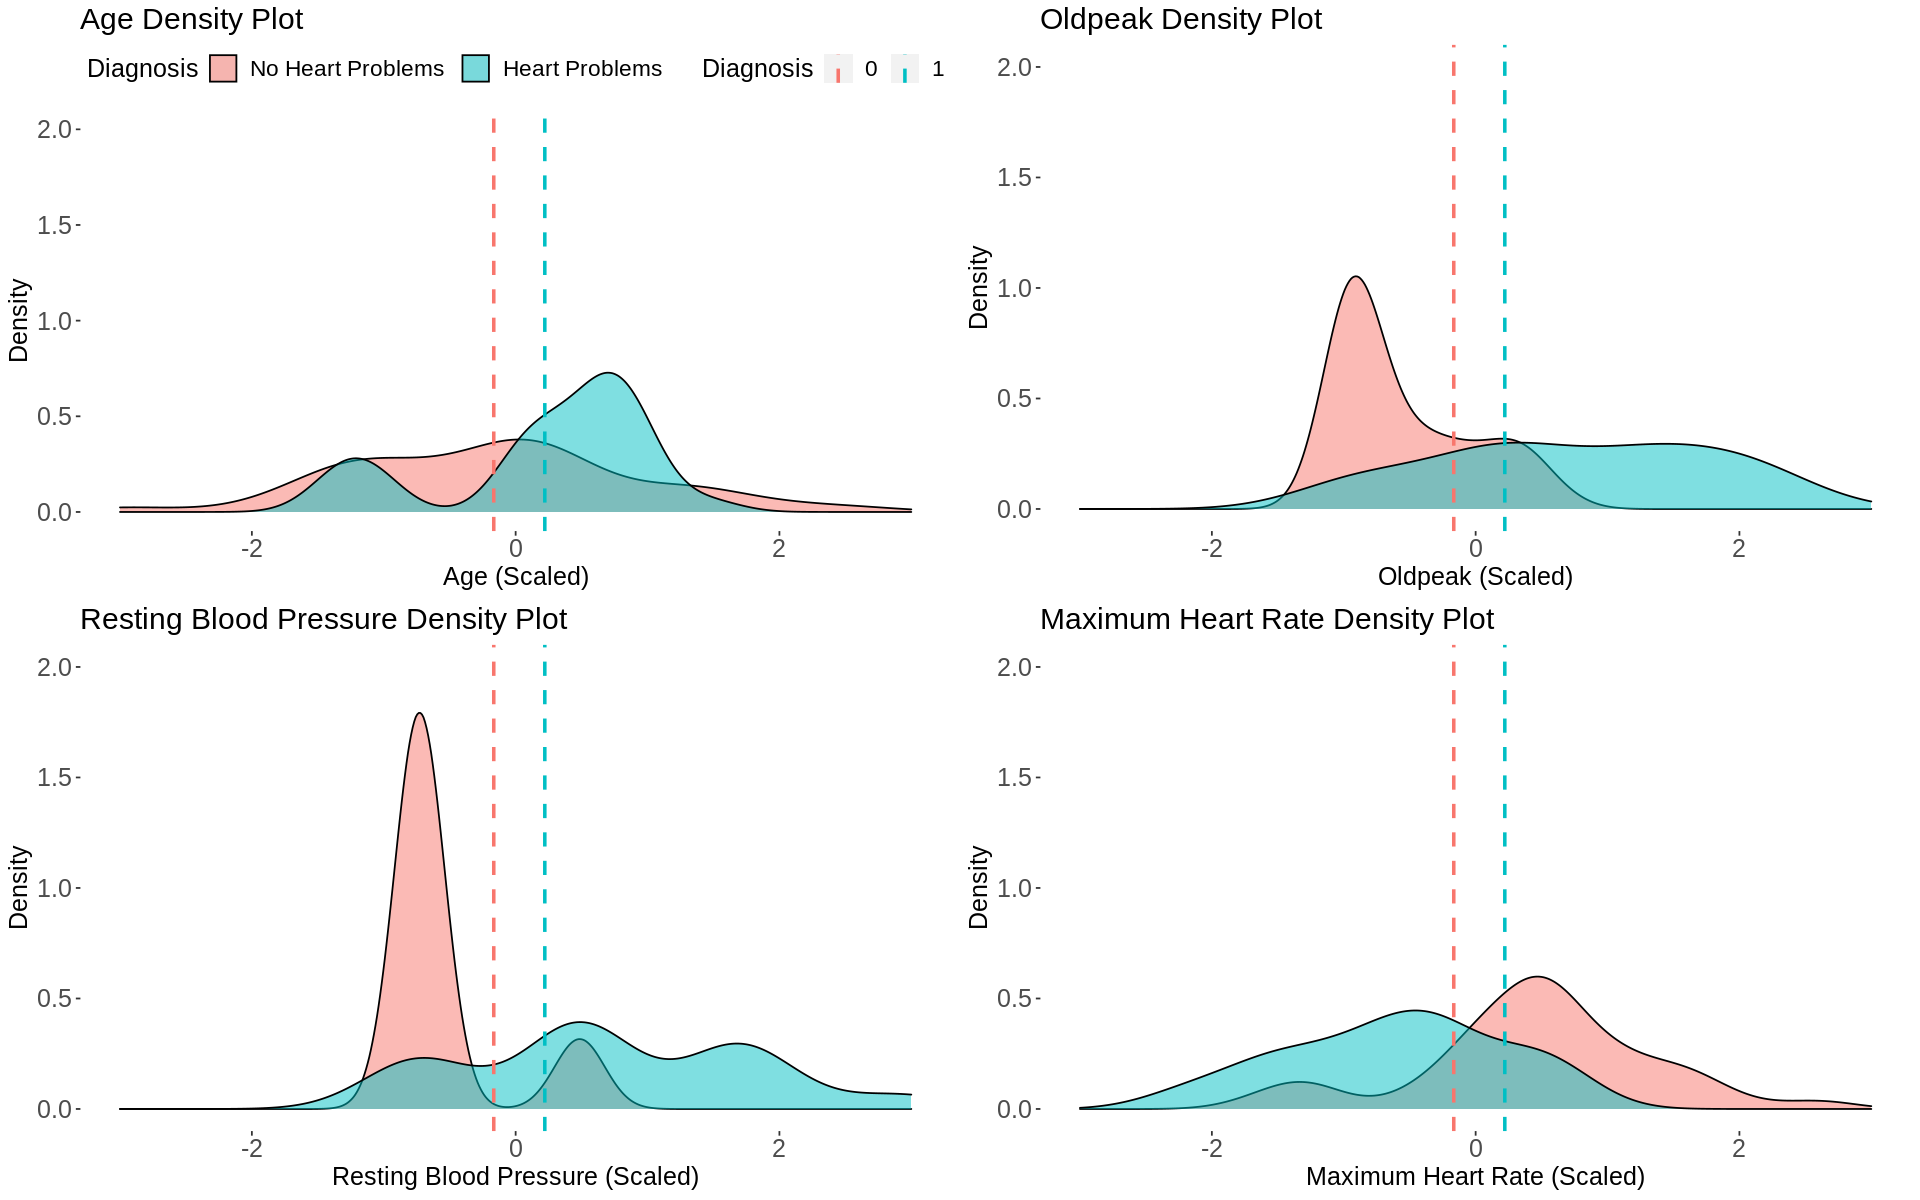

In [21]:
# Gathering the correctly predicted data to determine the factors that had
# the most weight in generating the correct prediction

correct_pred        <- heart_predictions                                    %>%
                       filter(.pred_class == diagnosis)   


correct_pred_scaled <- correct_pred                                         %>%
                       mutate(age           = scale(age),
                              oldpeak       = scale(oldpeak),
                              nmajorvessels = scale(nmajorvessels),
                              maxheartrate  = scale(maxheartrate))          


averages            <- correct_pred_scaled                                  %>%
                       group_by(diagnosis)                                  %>%
                       summarise(mean_age     = mean(age),
                                 mean_oldpeak = mean(oldpeak),
                                 mean_nmv     = mean(nmajorvessels),
                                 mean_max_hr  = mean(maxheartrate))               


# Creating scaled density plots with equal limits to ensure fair comparison

age_plot     <- ggplot(correct_pred_scaled, aes(x = age, fill = diagnosis)) +
                 geom_density(alpha=  0.5)                                  +
                 geom_vline(data = averages, 
                            aes(xintercept = mean_age, 
                                colour     = diagnosis),
                                linetype   = "dashed", 
                                size       = 1)                             +
                 labs(x      = "Age (Scaled)",
                      y      = "Density",
                      colour = "Diagnosis",
                      title  = "Age Density Plot")                          +
                 xlim(c(-3, 3))                                             +
                 ylim(c(0,  2))                                             +
                 scale_fill_discrete(name = "Diagnosis",
                                     labels = c("No Heart Problems",
                                                "Heart Problems"))          +
                 theme(axis.text.x = element_text(size = 15),
                       axis.text.y = element_text(size = 15),
                       title = element_text(size = 15),
                       text  = element_text(size = 17),
                       legend.position = "top",
                       panel.background = element_rect(fill = "transparent"))

oldpeak_plot <- ggplot(correct_pred_scaled, aes(x    = oldpeak, 
                                         fill = diagnosis))                 +
                 geom_density(alpha=  0.5)                                  +
                 geom_vline(data = averages, 
                       aes(xintercept = mean_age, 
                           colour     = diagnosis),
                           linetype   = "dashed", 
                           size       = 1)                                  +
                 labs(x      = "Oldpeak (Scaled)",
                      y      = "Density",
                      colour = "Diagnosis",
                      title  = "Oldpeak Density Plot")                      +
                 xlim(c(-3, 3))                                             +
                 ylim(c(0,  2))                                             +
                 theme(axis.text.x = element_text(size = 15),
                       axis.text.y = element_text(size = 15),
                       title = element_text(size = 15),
                       text  = element_text(size = 17),
                       legend.position = "none",
                       panel.background = element_rect(fill = "transparent"))


nmv_plot     <- ggplot(correct_pred_scaled, aes(x    = nmajorvessels, 
                                         fill = diagnosis))                 +
                 geom_density(alpha=  0.5)                                  +
                 geom_vline(data = averages, 
                           aes(xintercept = mean_age, 
                               colour     = diagnosis),
                               linetype   = "dashed", 
                               size       = 1)                              +
                 labs(x      = "Resting Blood Pressure (Scaled)",
                      y      = "Density",
                      colour = "Diagnosis",
                      title  = "Resting Blood Pressure Density Plot")       +
                 xlim(c(-3, 3))                                             +
                 ylim(c(0,  2))                                             +
                 theme(axis.text.x = element_text(size = 15),
                       axis.text.y = element_text(size = 15),
                       title = element_text(size = 15),
                       text  = element_text(size = 17),
                       legend.position = "none",
                       panel.background = element_rect(fill = "transparent"))
  
max_hr_plot  <- ggplot(correct_pred_scaled, aes(x    = maxheartrate, 
                                         fill = diagnosis))                 +
                 geom_density(alpha=  0.5)                                  +
                 geom_vline(data = averages, 
                            aes(xintercept = mean_age, 
                                color      = diagnosis),
                                linetype   = "dashed", 
                                size       = 1)                             +
                 labs(x      = "Maximum Heart Rate (Scaled)",
                      y      = "Density",
                      colour = "Diagnosis",
                      title  = "Maximum Heart Rate Density Plot")           +
                 xlim(c(-3, 3))                                             +
                 ylim(c(0,  2))                                             +
                 theme(axis.text.x = element_text(size = 15),
                       axis.text.y = element_text(size = 15),
                       title = element_text(size = 15),
                       text  = element_text(size = 17),
                       legend.position = "none",
                       panel.background = element_rect(fill = "transparent"))


options(repr.plot.width = 16, repr.plot.height = 10)
plot_grid(age_plot, oldpeak_plot, nmv_plot,max_hr_plot, ncol = 2)

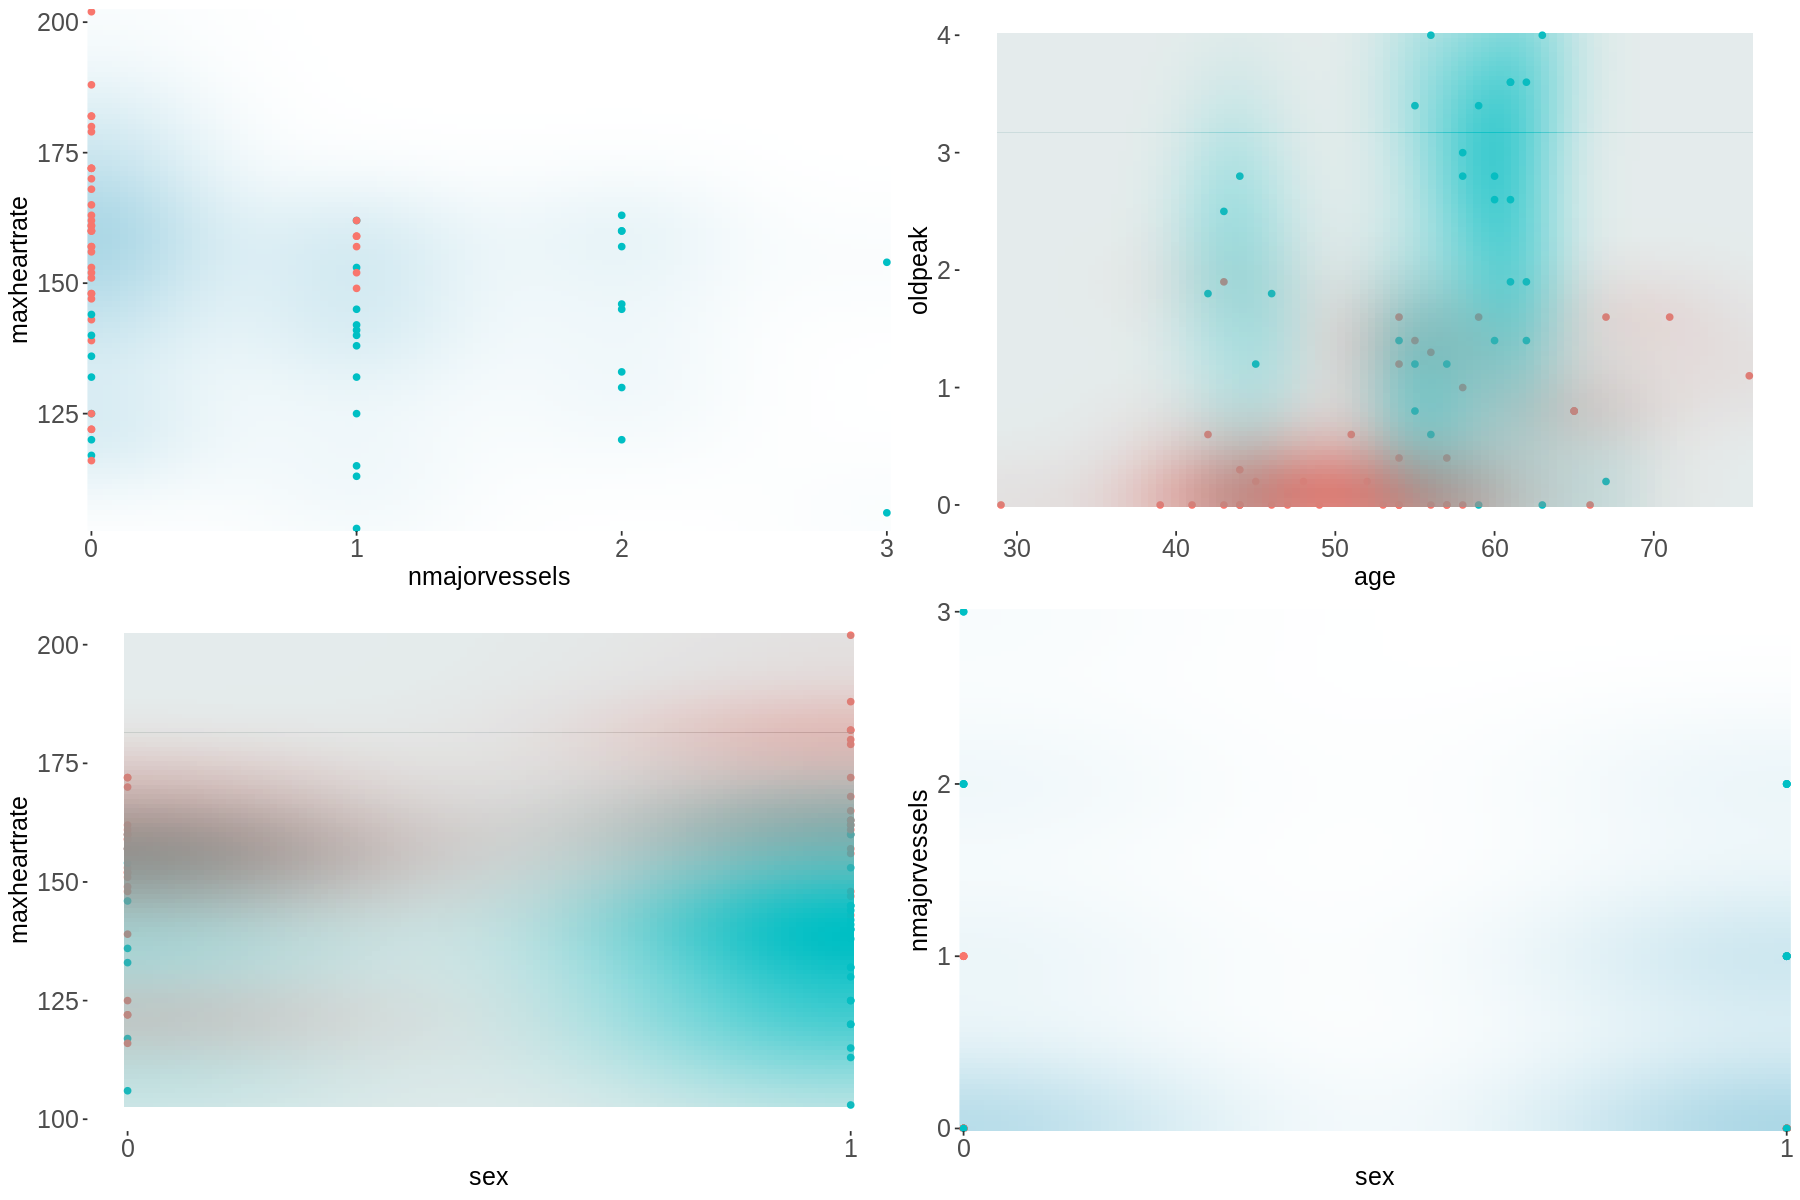

In [22]:
options(repr.plot.width = 10, repr.plot.height = 5)
#                scale_fill_distiller(palette= "Set2", direction=1)           +


nmv_vs_mhr <- ggplot(correct_pred)                                          +
               stat_density_2d(aes(x = nmajorvessels, 
                                   y = maxheartrate,
                                   fill = ..density..), 
                               geom = "raster", contour = FALSE)            +
               geom_point(aes(x = nmajorvessels, 
                              y = maxheartrate,
                              colour = diagnosis))                          +
               scale_fill_continuous(low = "white", high = "lightblue")     +
               scale_x_continuous(expand = c(0, 0))                         +
               scale_y_continuous(expand = c(0, 0))                         +
               theme(axis.text.x = element_text(size = 15),
                     axis.text.y = element_text(size = 15),
                     title = element_text(size = 15),
                     text  = element_text(size = 17),
                     legend.position = "none",
                     panel.background = element_rect(fill = "transparent"))

age_vs_opk <- ggplot(correct_pred, aes(x     = age, 
                                       y     = oldpeak,
                                      colour = diagnosis))                  +
              geom_point()                                                  +
              stat_density2d(geom  = "tile", 
                             aes(fill     = diagnosis, 
                                 alpha    = ..density..), 
                            contour  = FALSE,
                            linetype = 0)                                   +
              theme(axis.text.x = element_text(size = 15),
                    axis.text.y = element_text(size = 15),
                    title = element_text(size = 15),
                    text  = element_text(size = 17),
                    legend.position = "none",
                    panel.background = element_blank())

mhr_vs_sex <- ggplot(correct_pred, aes(x      = sex, 
                                       y      = maxheartrate,
                                       colour = diagnosis))                 +
              geom_point()                                                  +
              stat_density2d(geom  = "tile", 
                             aes(fill     = diagnosis, 
                                 alpha    = ..density..), 
                             contour  = FALSE,
                             linetype = 0)                                  +
              scale_x_continuous(breaks = seq(0, 1 , 1))                    +
              theme(axis.text.x = element_text(size = 15),
                    axis.text.y = element_text(size = 15),
                    title = element_text(size = 15),
                    text  = element_text(size = 17),
                    legend.position  = "none",
                    panel.background = element_blank())

nmj_vs_sex <- ggplot(correct_pred)                                          +
               stat_density_2d(aes(x    = sex, 
                                   y    = nmajorvessels,
                                   fill = ..density..), 
                               geom = "tile", contour = FALSE)              +
               geom_point(aes(x = sex, 
                              y = nmajorvessels,
                              colour = diagnosis))                          +
               scale_fill_continuous(low = "white", high = "lightblue")     +
               scale_x_continuous(expand = c(0, 0),
                                  breaks = seq(0, 1, 1))                    +
               scale_y_continuous(expand = c(0, 0))                         +
               theme(axis.text.x = element_text(size = 15),
                     axis.text.y = element_text(size = 15),
                     title = element_text(size = 15),
                     text  = element_text(size = 17),
                     legend.position  = "none",
                     panel.background = element_rect(fill = "transparent"))

options(repr.plot.width = 15, repr.plot.height = 10)

plot_grid(nmv_vs_mhr, age_vs_opk,mhr_vs_sex, nmj_vs_sex, ncol = 2)
# plot_grid(mhr_vs_sex, nmj_vs_sex, ncol = 2)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.023756 11.009”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.5314”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 6.3322”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.010072 7.4241”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 4.6302”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.471e-17”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are ot

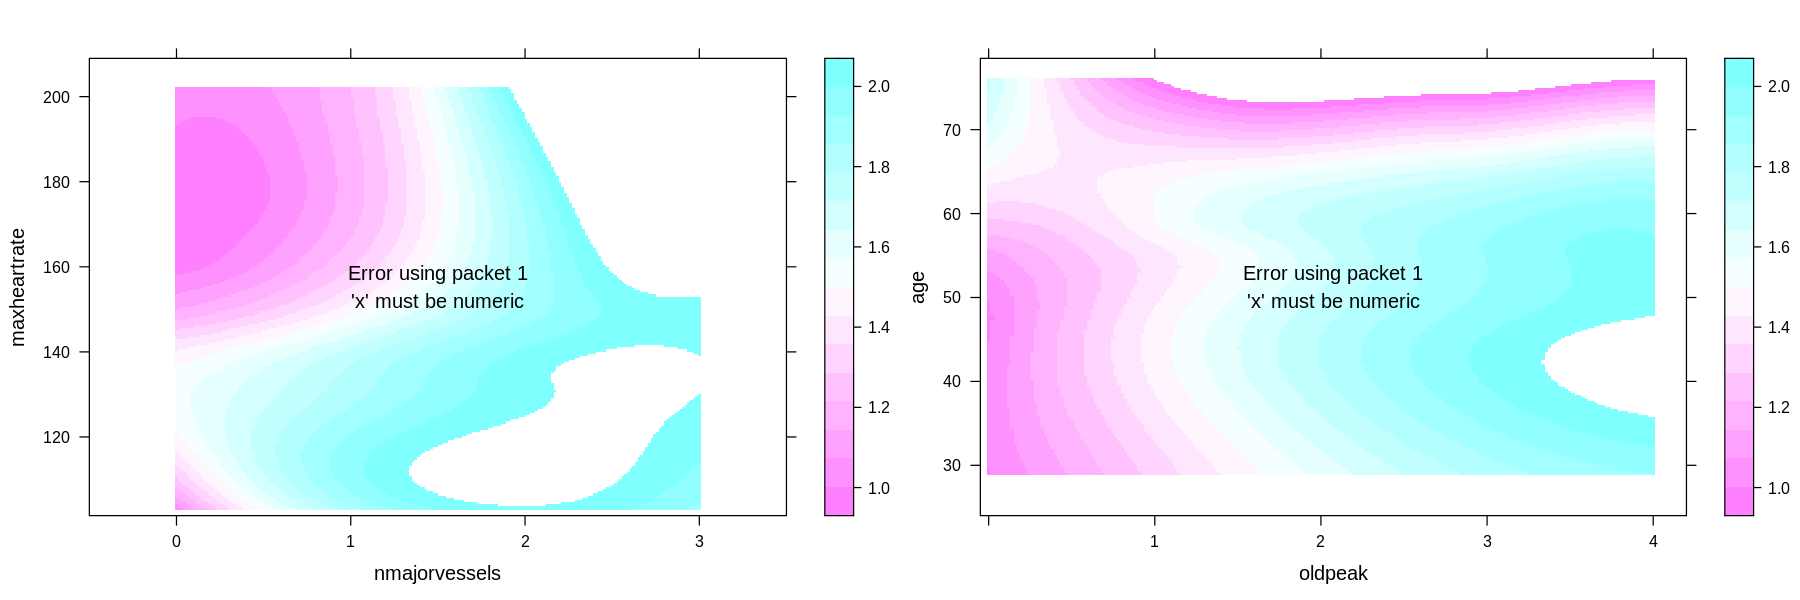

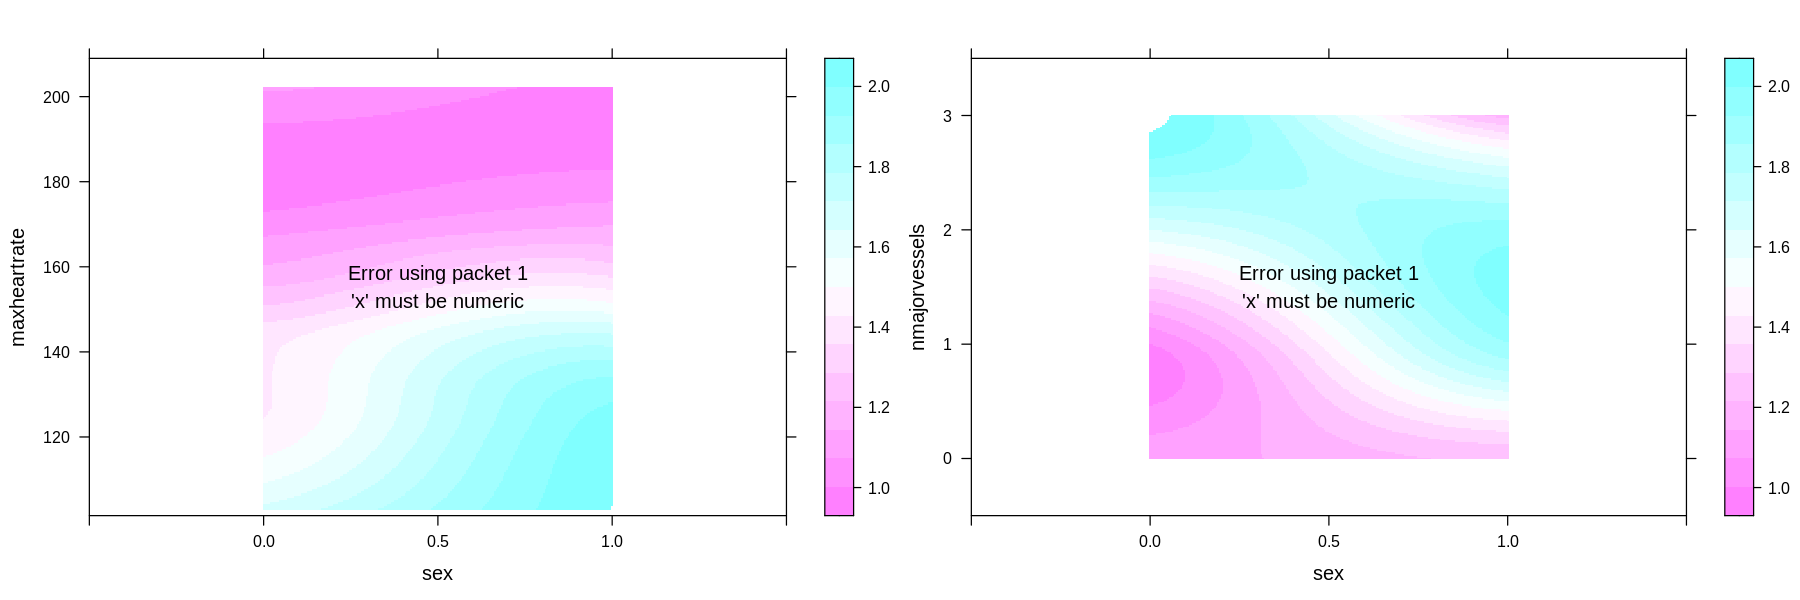

In [23]:
#install.packages("latticeExtra")
options(repr.plot.width = 15, repr.plot.height = 5)

library(latticeExtra) 

mhr_vs_nmv <- levelplot(diagnosis ~ nmajorvessels * maxheartrate , 
                        correct_pred, 
                        panel = panel.levelplot.points, cex = 1.2)          + 
              layer_(panel.2dsmoother(..., n = 200))


opk_vs_age <- levelplot(diagnosis ~ oldpeak * age, 
                        correct_pred, 
                        panel = panel.levelplot.points, cex = 1.2)          + 
              layer_(panel.2dsmoother(..., n = 200))


sex_vs_mhr <- levelplot(diagnosis ~  sex * maxheartrate, 
                        correct_pred, 
                        panel = panel.levelplot.points, cex = 1.2)          + 
              layer_(panel.2dsmoother(..., n = 200))


sex_vs_nmj <- levelplot(diagnosis ~ sex * nmajorvessels, 
                        correct_pred, 
                        panel = panel.levelplot.points, cex = 1.2)          + 
              layer_(panel.2dsmoother(..., n = 200))

plot_grid(mhr_vs_nmv, opk_vs_age, ncol = 2)
plot_grid(sex_vs_mhr, sex_vs_nmj, ncol = 2)

## 3. Discussion

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## 4. References

At least two + source of the dataset